            spot
day             
1997-01-07  3.82
1997-01-08  3.80
1997-01-09  3.61
1997-01-10  3.92
1997-01-13  4.00
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6563 entries, 1997-01-07 to 2023-01-10
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   spot    6563 non-null   float64
dtypes: float64(1)
memory usage: 102.5 KB
None


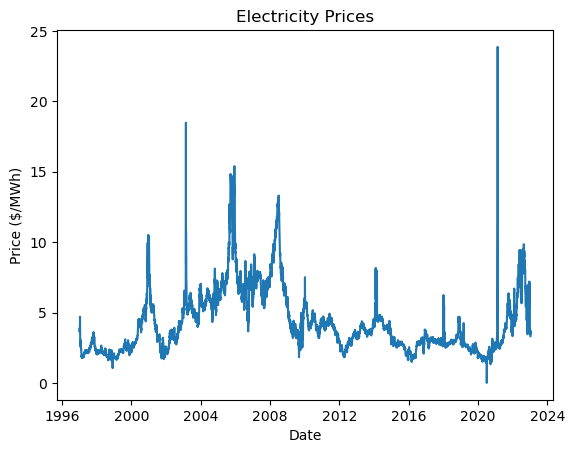

ADF Statistic: -4.185645574008752
p-value: 0.0006967507142924851
Critical Values:
   1%: -3.4313478435403866
   5%: -2.861980961981726
   10%: -2.5670047206318602


In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# Load the data into a pandas DataFrame
data = pd.read_csv('data/data_final.csv', sep = ";", parse_dates=['day'], decimal=",",index_col='day')[['spot']]
print(data.head())
print(data.info())
# Plot the time series
plt.plot(data)
plt.title('Electricity Prices')
plt.xlabel('Date')
plt.ylabel('Price ($/MWh)')
plt.show()

# Perform the ADF test
result = adfuller(data['spot'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

In [14]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")


import tensorflow as tf
import os
from tensorflow.keras import layers, models
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import plotly.express as px
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

2023-03-20 09:31:31.549268: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
fig = px.histogram(data, x = "spot", template = 'plotly_dark')
fig.show()

In [16]:
def test_stationarity(timeseries):
    
    # Determing rolling statistics
    rolmean = timeseries.rolling(25).mean()
    rolstd = timeseries.rolling(25).std()

    # Plot rolling statistics:
    plt.figure(figsize = (20,10))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        
    print(dfoutput)

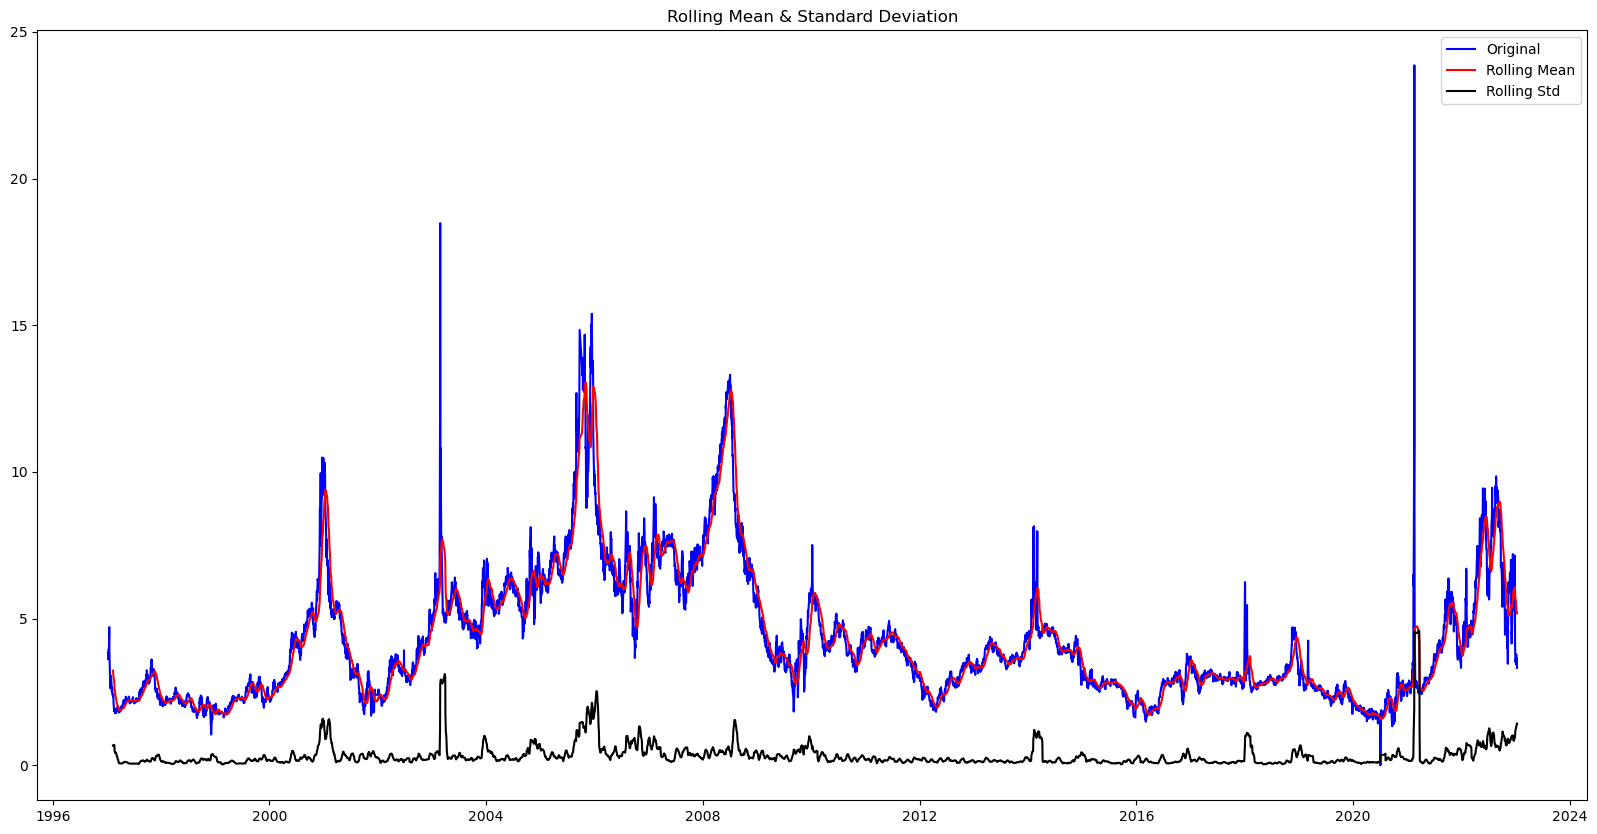

Results of Dickey-Fuller Test:
Test Statistic                   -4.185646
p-value                           0.000697
#Lags Used                        6.000000
Number of Observations Used    6556.000000
Critical Value (1%)              -3.431348
Critical Value (5%)              -2.861981
Critical Value (10%)             -2.567005
dtype: float64


In [17]:
test_stationarity(data)

Test Statistics shows how closely your observed data match the distribution expected under the null hypothesis of that statistical test.

Test Statistic < Critical Value & p-value < 0.05. Hence we reject the Null Hypothesis.

Data is Stationary.

However, There are 2 major reasons behind non-stationaruty of a TS:

Trend – Varying mean over time.

Seasonality – Variations at specific time-frames.

If TS is non-stationary: Estimate the trend and seasonality in the ts and remove it.

Final step: To convert the forecasted values into the original scale by applying trend and seasonality constraints back.

More less test statistic value more trend in pattern.

Simple Trend Reduction Techniques: Moving Average and Exponential Weighted Moving Average.

The simple trend reduction techniques don’t work with high seasonality. There we use following methods.

Differencing – Taking the difference with a particular Time Lag. Subtracting Current observation from previous.

Decomposition – Modeling both trend and seasonality and removing them from the model. Residuals of LR. Additive Dec.

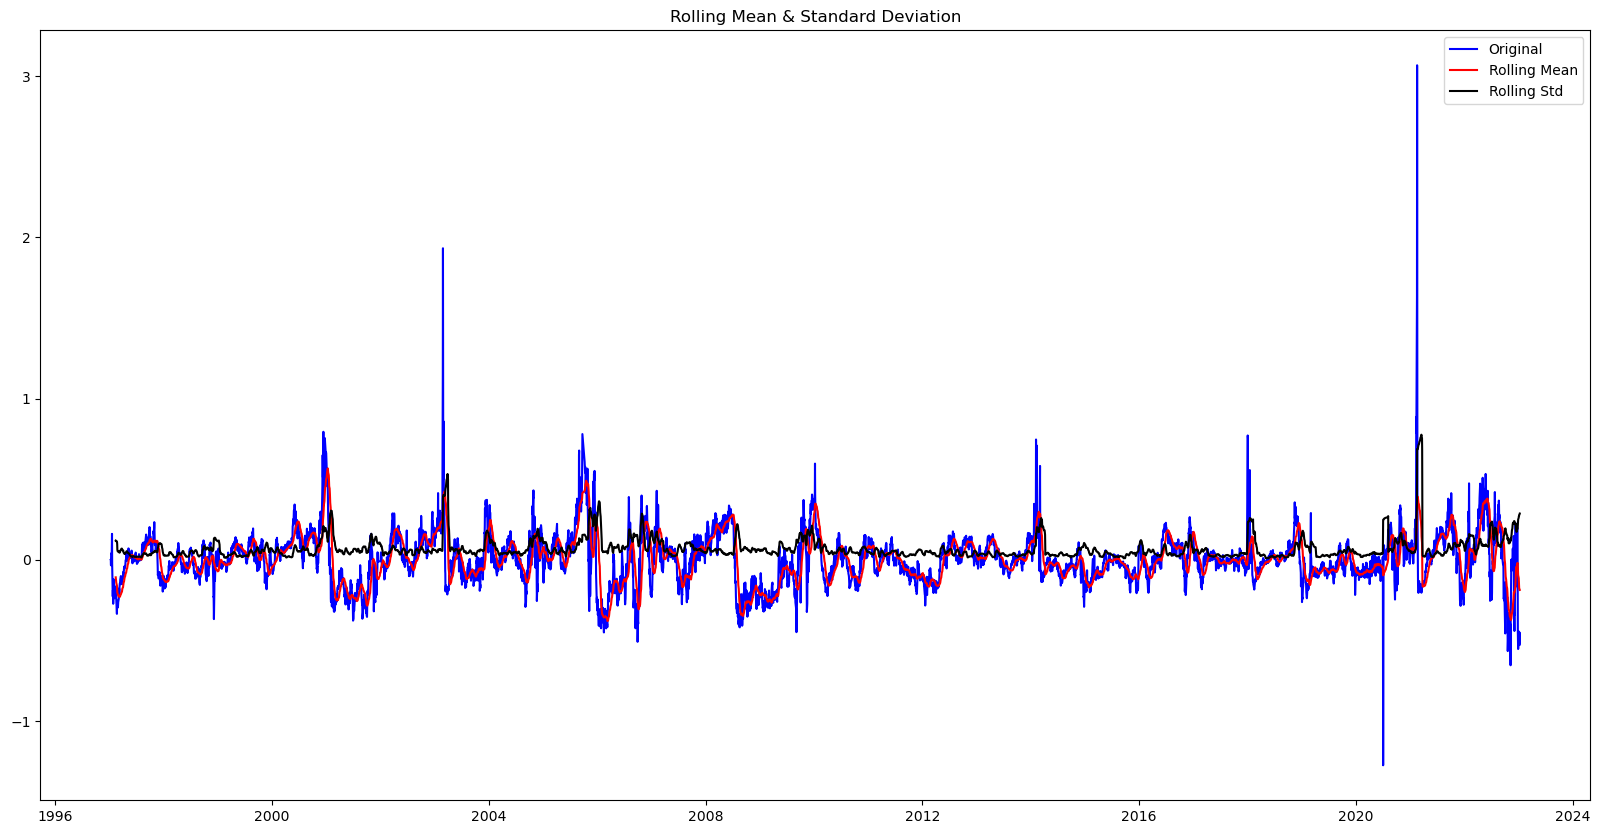

Results of Dickey-Fuller Test:
Test Statistic                -1.105549e+01
p-value                        4.956982e-20
#Lags Used                     1.100000e+01
Number of Observations Used    6.551000e+03
Critical Value (1%)           -3.431349e+00
Critical Value (5%)           -2.861981e+00
Critical Value (10%)          -2.567005e+00
dtype: float64


In [18]:
ts_sqrt = np.sqrt(data)
expwighted_avg = ts_sqrt.ewm(halflife = 25).mean()

ts_sqrt_ewma_diff = ts_sqrt - expwighted_avg
test_stationarity(ts_sqrt_ewma_diff)

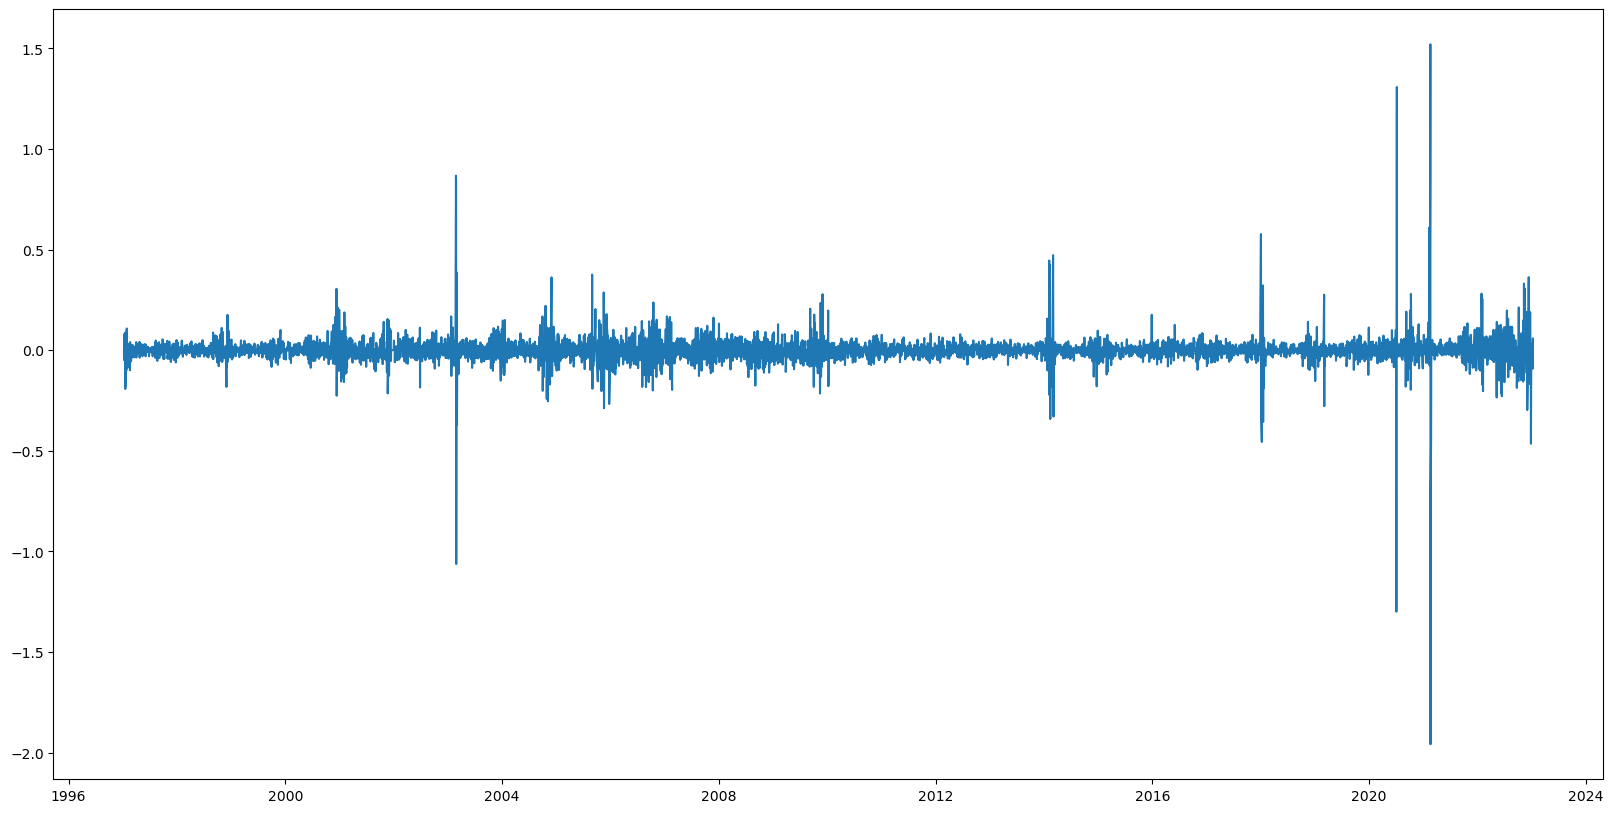

In [19]:
ts_sqrt_diff = ts_sqrt - ts_sqrt.shift()

plt.figure(figsize = (20,10))
plt.plot(ts_sqrt_diff)
plt.show()

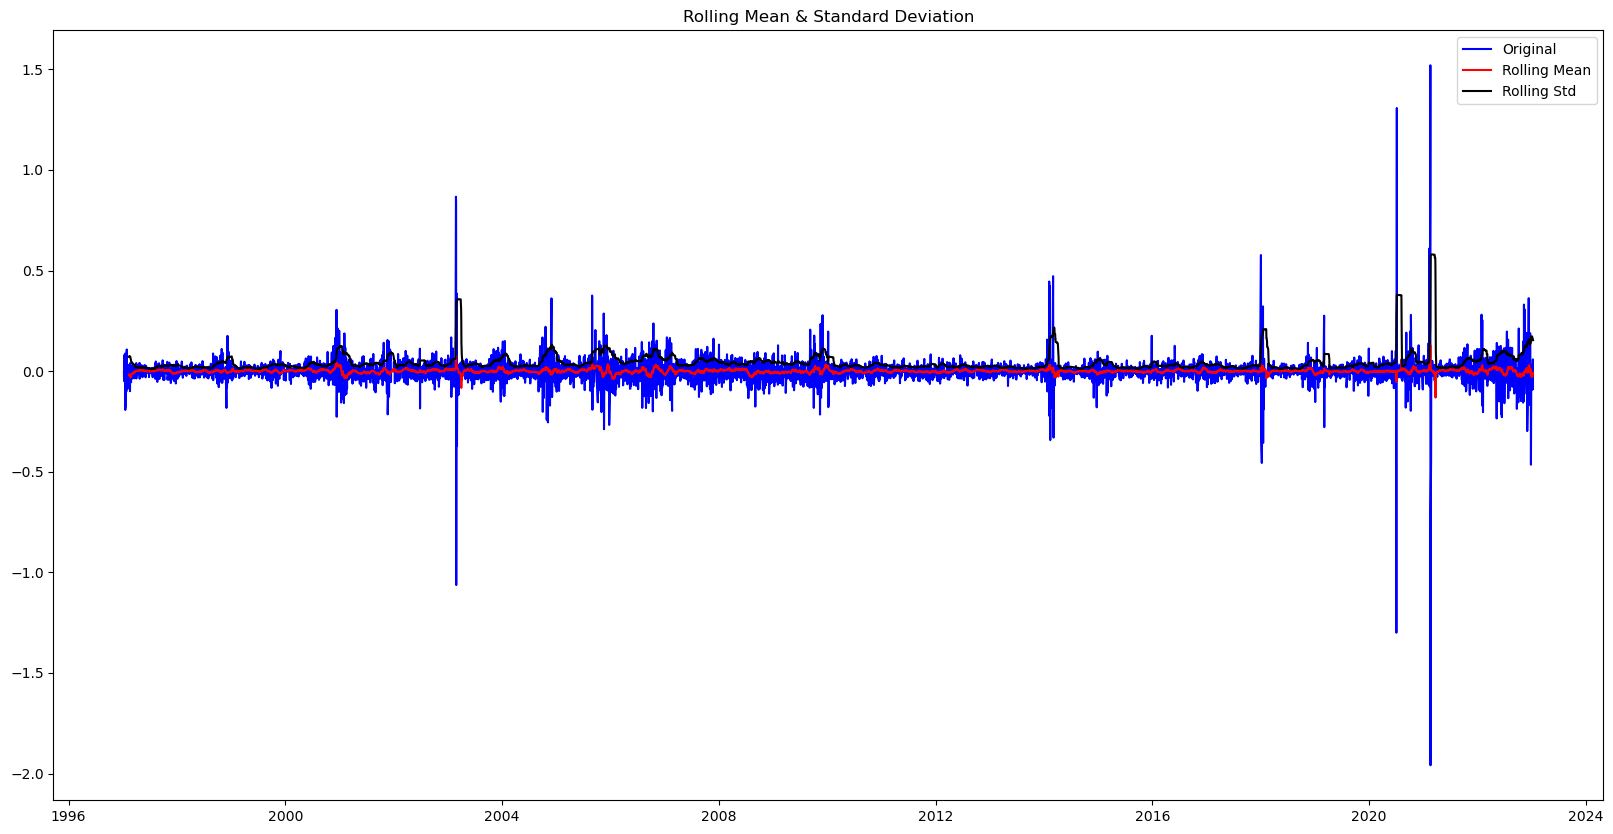

Results of Dickey-Fuller Test:
Test Statistic                  -27.406363
p-value                           0.000000
#Lags Used                       10.000000
Number of Observations Used    6551.000000
Critical Value (1%)              -3.431349
Critical Value (5%)              -2.861981
Critical Value (10%)             -2.567005
dtype: float64


In [20]:
ts_sqrt = np.sqrt(data)
ts_sqrt_diff = ts_sqrt - ts_sqrt.shift()
ts_sqrt_diff.dropna(inplace = True)
test_stationarity(ts_sqrt_diff)

Test Statistic < Critical Value and also there is less diversion in mean and std. This is perfect stationary ts.


In [21]:
data = data.sort_values(by = 'day')

train = data['1997-01-06': '2020-01-06'] # 7 Jan 1997 to 6 Jan 2021 
test = data['2020-01-07': '2022-03-01'] # 7 Jan 2021  to 1 Mar 2022 

print("Length of Train Data: ", len(train))
print("Length of Test Data: ", len(test))

Length of Train Data:  5790
Length of Test Data:  551


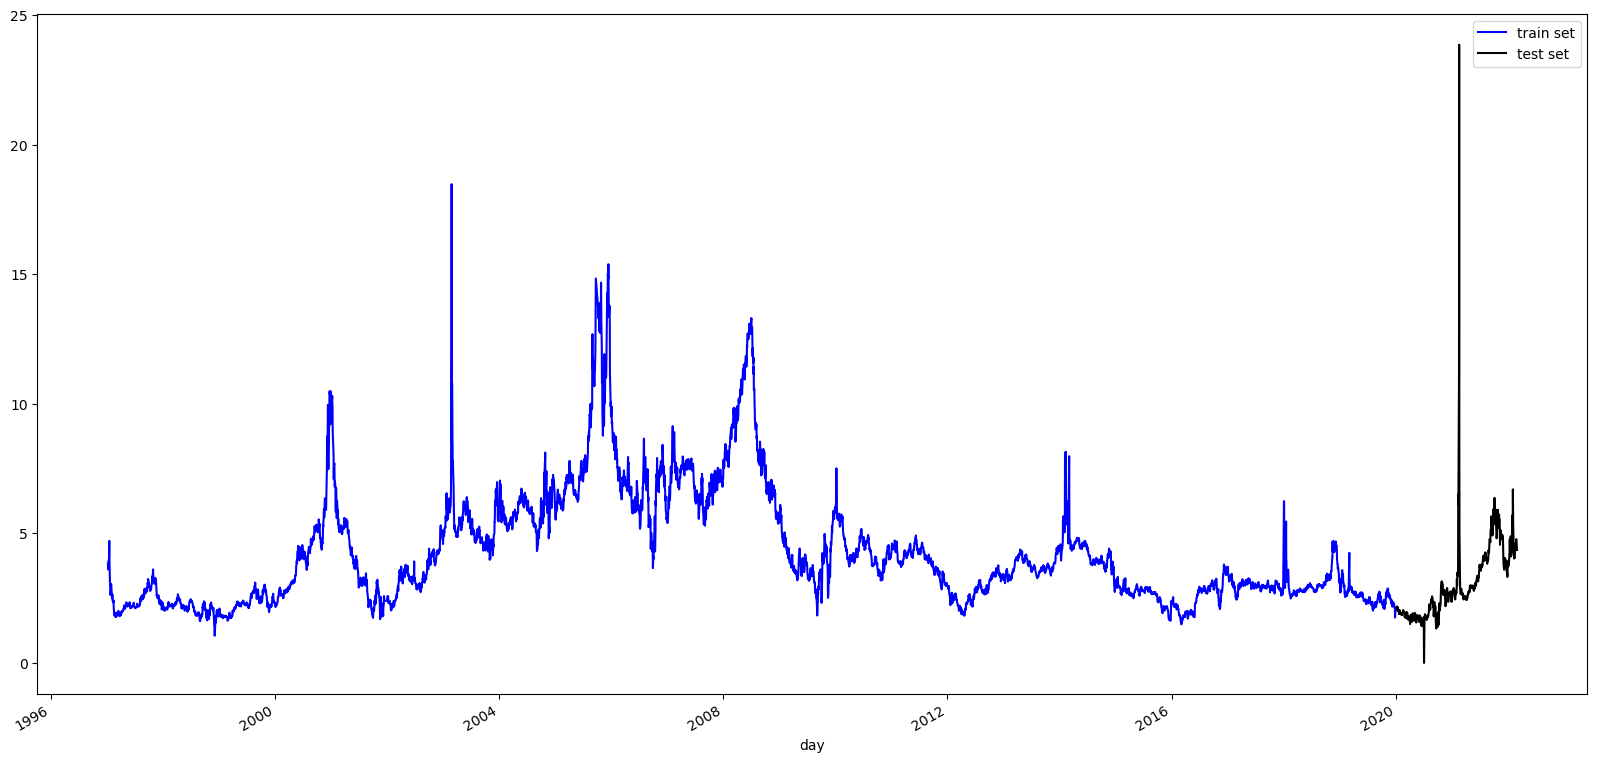

In [22]:
ax = train.plot(figsize = (20, 10), color = 'b')
test.plot(ax = ax, color = 'black')
plt.legend(['train set', 'test set'])
plt.show()

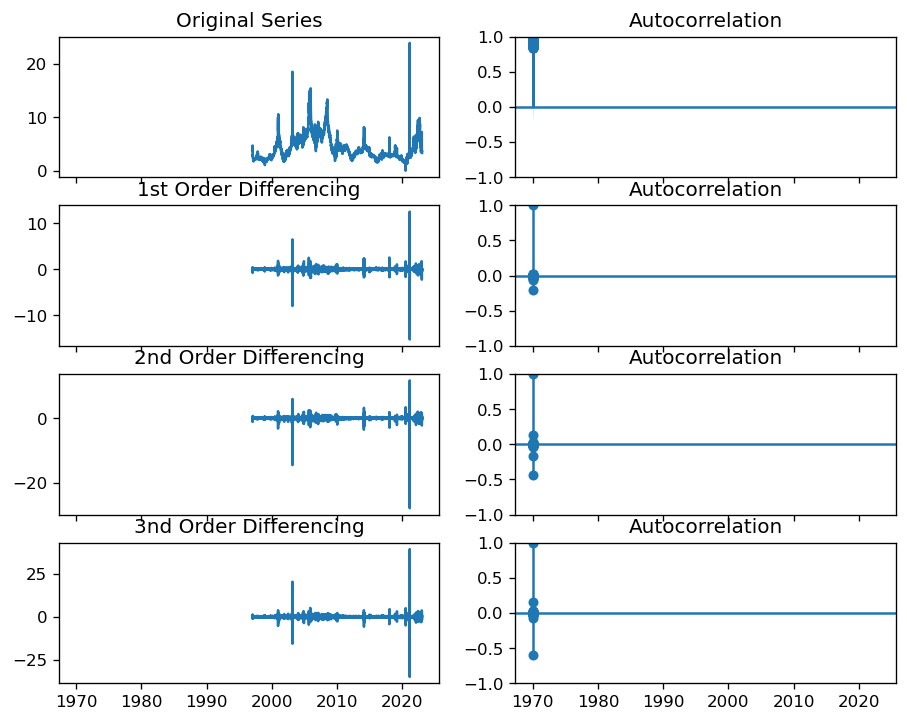

In [25]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(4, 2, sharex=True)
axes[0, 0].plot(data.spot); axes[0, 0].set_title('Original Series')
plot_acf(data.spot, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(data.spot.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(data.spot.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(data.spot.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(data.spot.diff().diff().dropna(), ax=axes[2, 1])

# 3rd Differencing
axes[3, 0].plot(data.spot.diff().diff().diff()); axes[3, 0].set_title('3nd Order Differencing')
plot_acf(data.spot.diff().diff().diff().dropna(), ax=axes[3, 1])

plt.show()

We will find out the required number of AR terms by inspecting the Partial Autocorrelation (PACF) plot.

Partial autocorrelation can be imagined as the correlation between the series and its lag

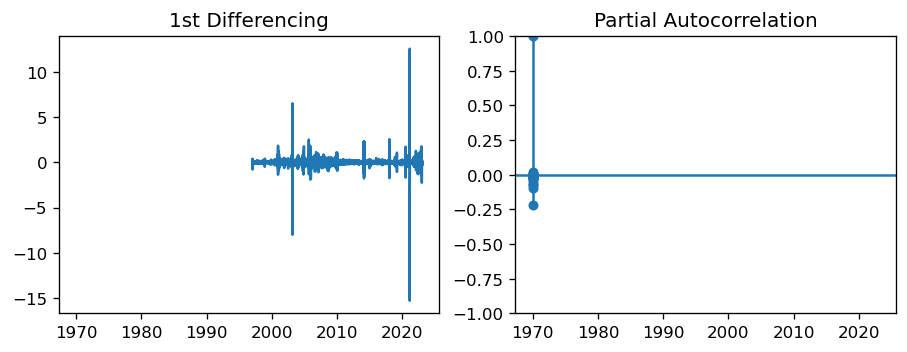

In [26]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(data.spot.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(data.spot.diff().dropna(), ax=axes[1])

plt.show()

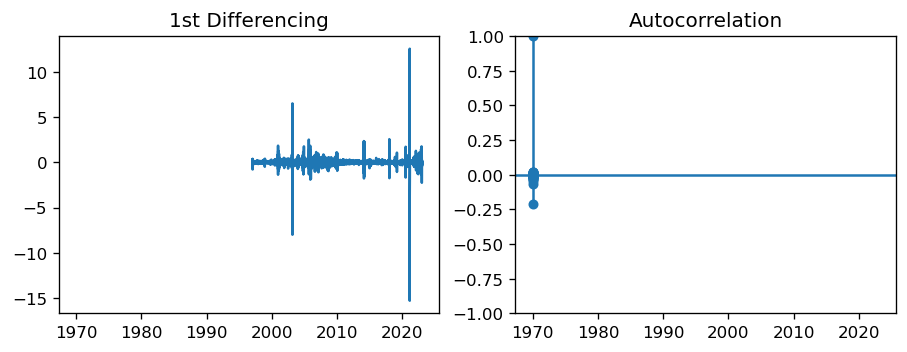

In [27]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)

axes[0].plot(data.spot.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(data.spot.diff().dropna(), ax=axes[1])

plt.show()

In [28]:
model = sm.tsa.arima.ARIMA(train, order = (1, 2, 1))
arima_model = model.fit() 
print(arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                   spot   No. Observations:                 5790
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -664.974
Date:                Mon, 20 Mar 2023   AIC                           1335.948
Time:                        09:37:19   BIC                           1355.939
Sample:                             0   HQIC                          1342.903
                               - 5790                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0092      0.002      5.128      0.000       0.006       0.013
ma.L1         -1.0000      0.033    -30.389      0.000      -1.064      -0.935
sigma2         0.0736      0.002     30.693      0.0

In [29]:
yp_train = arima_model.predict(start = 0, end = (len(train)-1))
yp_test = arima_model.predict(start = 0, end = (len(test)-1)) 

print("Train Data:\nMean Square Error: {}".format(mean_squared_error(train, yp_train)))
print("\nTest Data:\nMean Square Error: {}".format(mean_squared_error(test, yp_test)))

Train Data:
Mean Square Error: 0.07679331404552024

Test Data:
Mean Square Error: 3.8637375458869356


In [31]:
slot = 15

x_train = []
y_train = []

for i in range(slot, len(train)):
    x_train.append(train.iloc[i-slot:i, 0])
    y_train.append(train.iloc[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print(x_train.shape, y_train.shape)

(5775, 15, 1) (5775,)


In [45]:
x_train

array([[[3.82],
        [3.8 ],
        [3.61],
        ...,
        [2.96],
        [2.62],
        [2.98]],

       [[3.8 ],
        [3.61],
        [3.92],
        ...,
        [2.62],
        [2.98],
        [3.05]],

       [[3.61],
        [3.92],
        [4.  ],
        ...,
        [2.98],
        [3.05],
        [2.91]],

       ...,

       [[2.28],
        [2.28],
        [2.34],
        ...,
        [2.06],
        [2.09],
        [2.09]],

       [[2.28],
        [2.34],
        [2.3 ],
        ...,
        [2.09],
        [2.09],
        [2.05]],

       [[2.34],
        [2.3 ],
        [2.26],
        ...,
        [2.09],
        [2.05],
        [2.06]]])

In [46]:
data

,spot
day,
1997-01-07,3.82
1997-01-08,3.80
1997-01-09,3.61
1997-01-10,3.92
1997-01-13,4.00
...,...
2023-01-04,3.75
2023-01-05,3.78
2023-01-06,3.43


In [32]:
lstm_model = tf.keras.Sequential()
lstm_model.add(tf.keras.layers.LSTM(units = 50, input_shape = (slot, 1), return_sequences = True, activation = 'relu'))
#lstm_model.add(tf.keras.layers.Dropout(0.01))
lstm_model.add(tf.keras.layers.LSTM(units = 50, activation = 'relu', return_sequences = True))
#lstm_model.add(tf.keras.layers.Dropout(0.01))
lstm_model.add(tf.keras.layers.LSTM(units = 50, return_sequences = True))
#lstm_model.add(tf.keras.layers.Dropout(0.01))
lstm_model.add(tf.keras.layers.LSTM(units = 50, return_sequences = False))
#lstm_model.add(tf.keras.layers.Dropout(0.01))
lstm_model.add(tf.keras.layers.Dense(units = 1))
lstm_model.compile(loss = 'mean_squared_error', optimizer = 'adam')

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 15, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 15, 50)            20200     
                                                                 
 lstm_2 (LSTM)               (None, 15, 50)            20200     
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________


In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 7)

history = lstm_model.fit(x_train, y_train, epochs = 100, 
                         batch_size = 64, 
                         verbose = 1, shuffle = False, 
                         callbacks = [early_stopping])

In [34]:
yp_train = lstm_model.predict(x_train)
a = pd.DataFrame(yp_train)
a.rename(columns = {0: 'gp_pred'}, inplace = True); 
a.index = train.iloc[slot:].index
train_compare = pd.concat([train.iloc[slot:], a], 1)

181/181 [==============================] - 2s 6ms/step


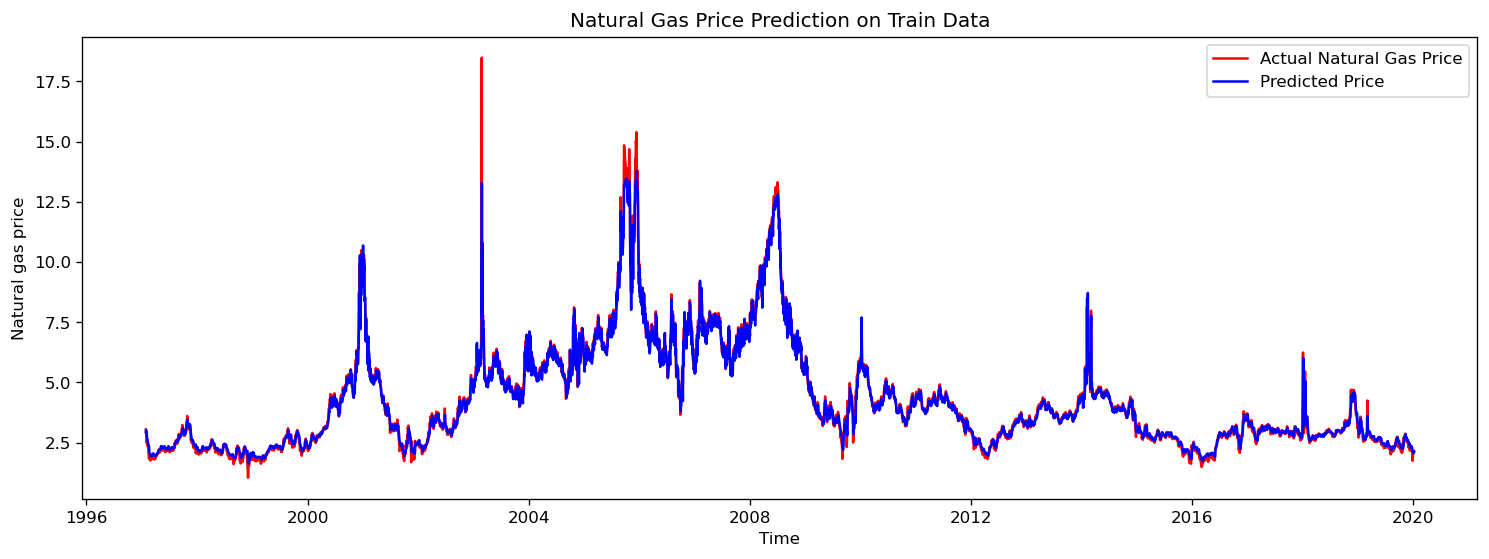

In [36]:
plt.figure(figsize = (15, 5))
plt.plot(train_compare['spot'], color = 'red', label = "Actual Natural Gas Price")
plt.plot(train_compare['gp_pred'], color = 'blue', label = 'Predicted Price')
plt.title("Natural Gas Price Prediction on Train Data")
plt.xlabel('Time')
plt.ylabel('Natural gas price')
plt.legend(loc = 'best')
plt.show()

In [37]:
dataset_total = pd.concat((train, test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test)- slot:].values
inputs = inputs.reshape(-1, 1)

x_test = []
y_test = []
for i in range (slot, len(test)+slot): #Test+15
    x_test.append(inputs[i-slot:i, 0])
    y_test.append(train.iloc[i, 0])
      
x_test, y_test = np.array(x_test), np.array(y_test)

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
pred_price = lstm_model.predict(x_test)

18/18 [==============================] - 0s 6ms/step


In [38]:
b = pd.DataFrame(pred_price)
b.rename(columns = {0: 'gp_pred'}, inplace = True); 
b.index = test.index
test_compare = pd.concat([test, b], 1)

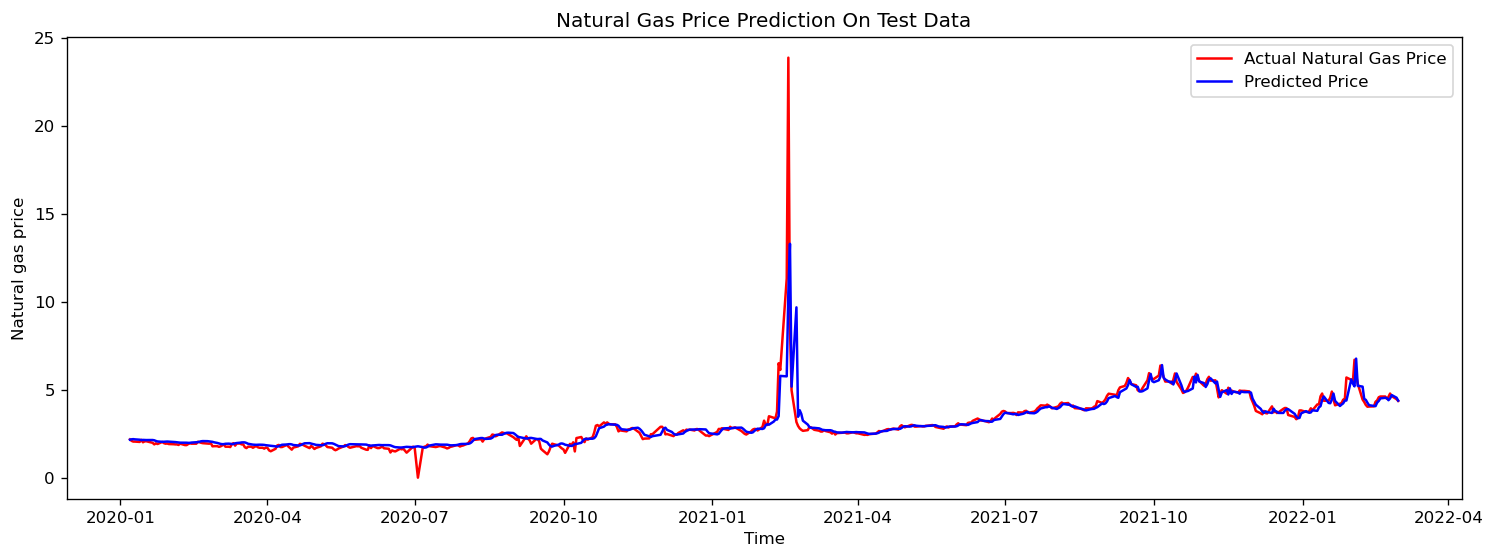

In [39]:
plt.figure(figsize = (15,5))
plt.plot(test_compare['spot'], color = 'red', label = "Actual Natural Gas Price")
plt.plot(test_compare['gp_pred'], color = 'blue', label = 'Predicted Price')
plt.title("Natural Gas Price Prediction On Test Data")
plt.xlabel('Time')
plt.ylabel('Natural gas price')
plt.legend(loc = 'best')
plt.show()

In [41]:
mse_train = mean_squared_error(train_compare['spot'], train_compare['gp_pred'])
mse_test = mean_squared_error(test_compare['spot'], test_compare['gp_pred'])

r2_train = r2_score(train_compare['spot'], train_compare['gp_pred'])
r2_test = r2_score(test_compare['spot'], test_compare['gp_pred'])

print("Train Data:\nMSE: {}\nR Square: {}".format(mse_train, r2_train))
print("\nTest Data:\nMSE: {}\nR Square: {}".format(mse_test, r2_test))

Train Data:
MSE: 0.07462566732409623
R Square: 0.9843882682085136

Test Data:
MSE: 0.5661510518444779
R Square: 0.7703830962418319


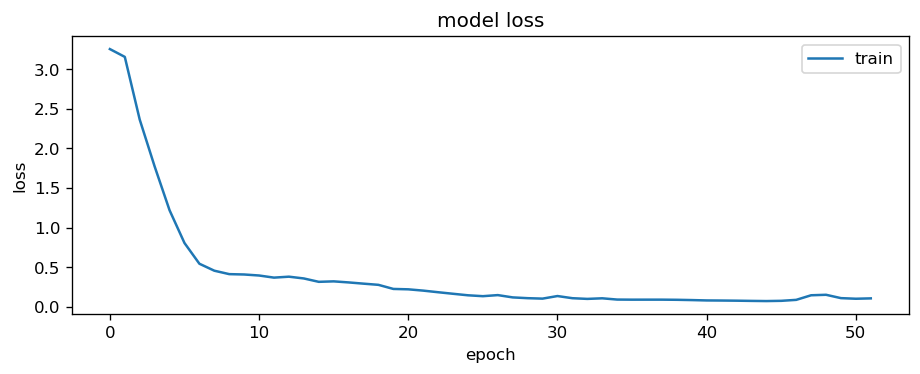

In [42]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

In [43]:
forecast = pd.DataFrame({'date': pd.date_range(start = '3/2/2022', end = '3/20/2022')}) # 2 March to 20 March 

inputs = test[len(test) - slot: ].values

for i in range(slot, len(forecast)): 
    inputs = inputs.T
    inputs = np.reshape(inputs, (inputs.shape[0], inputs.shape[1], 1))
    pred_price = lstm_model.predict(inputs[:,i-slot:i])
    inputs = np.append(inputs, pred_price)
    inputs = np.reshape(inputs, (inputs.shape[0], 1))

forecast['gp_pred'] = inputs
forecast = forecast.set_index('date')

1/1 [==============================] - 0s 22ms/step


In [44]:
forecast.reset_index(inplace = True)

fig = px.line(forecast, x = "date", y = "gp_pred", title = 'Natural Gas Price Forecasting', template = 'plotly_dark')
fig.show()

In [ ]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

# Load the data
data = pd.read_csv('electricity_prices.csv', header=0, index_col=0, parse_dates=True, squeeze=True)

# Preprocess the data
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data.values.reshape(-1, 1))

# Split the data into training and test sets
train_size = int(len(data) * 0.8)
test_size = len(data) - train_size
train_data, test_data = data[0:train_size, :], data[train_size:len(data), :]

# Define the input sequence length and the number of features
seq_length = 24
num_features = 1

# Generate the training sequences
X_train = []
y_train = []
for i in range(seq_length, len(train_data)):
    X_train.append(train_data[i-seq_length:i, 0])
    y_train.append(train_data[i, 0])
X_train = np.array(X_train)
y_train = np.array(y_train)

# Generate the test sequences
X_test = []
y_test = []
for i in range(seq_length, len(test_data)):
    X_test.append(test_data[i-seq_length:i, 0])
    y_test.append(test_data[i, 0])
X_test = np.array(X_test)
y_test = np.array(y_test)

# Reshape the input data to fit the LSTM input format
X_train = np.reshape(X_train, (X_train.shape[0], seq_length, num_features))
X_test = np.reshape(X_test, (X_test.shape[0], seq_length, num_features))

# Define the LSTM model architecture
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(seq_length, num_features)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile the model and specify the loss function and optimizer
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Generate predictions on the test set
y_pred = model.predict(X_test)

# Rescale the predicted values
y_pred = scaler.inverse_transform(y_pred)

# Rescale the actual values
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate the mean squared error
mse = np.mean(np.square(y_test - y_pred))
print("Mean Squared Error: ", mse)
